In [1]:
from classes.connectivity_blocks import *
from classes.network_dynamics import *
from classes.task import *
from classes.functions_analysis import *
import torch as tch
import pandas
import scipy.io as sio
import pickle

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

In [8]:
def model_parameters():
    modelparams = dict(
            seed = 3,#4,
            #network parameters
            n_ctx = 180,
            N_block = 400, #neurons per region
            N_recorded = 200, #neurons recorded per region

            #transfer function Pereira&Brunel,18
            rm = 1,#76.2,
            beta = 1, #Pereira&Brunel
            h0 = .1,
            amp_offset = 1,

            #dynamics excitatory
            tau_ctx =  60 * 1e-3,#s mainly NMDA

            #private noise 
            sigma_noise = 0,

            #Low-d noise
            sigma_ld = 22,
            tau_ld = 100 * 1e-3,
            mu_ld = 0,
            
            #spines dependencies
            A_spines = 1,#10
            offset_spines = .1,
            
            #noise
            amp_loc_noise = 0.1,#0.0, #amp noise local dorsal
            amp_lr_noise = 0.1,#0.0, #ventral<->ventral amp noise long-range

            #hebbian 
            amp_loc = 1.,
            amp_lr = 1.,


            #stimulation parameters
            period = 10., # 20 seconds
            dt = 15. * 1e-3,# indegration time
            t_stim = .5, #period-t_stim when stimulus
            t_start = 2.5, #t_starts
            g_p= 1.5,

            g_sym = 0,
            g_asym = 0,
            g_random = 0,
            grad_NM= np.zeros(180)
            
            )
    return modelparams

In [9]:
def loading_matrices(gamma, path=''):
    ''' this functions load the matrices and normalize them'''
    PATH = path + 'connectivity_data/'
    tract = sio.loadmat(PATH + 'FSe_tractography.mat')
    serotonin =sio.loadmat('connectivity_data/human_data/HTR1A_genevals.mat')
    names_serotonin = sio.loadmat('connectivity_data/human_data/HCP_180_area_names_LH.mat')
    names_ctx = [tract['area_list_Sean_89'][0][l][0] for l in range(89)] 
    #fln = pickle.load(open(PATH + 'mat_tractography.p','rb'))
    con = sio.loadmat(open('connectivity_data/human_data/human_structural_conn.mat', 'rb'))
    matrix = con['lh_struct_conn_rownorm']
    fln = matrix
    t1_t2 =  sio.loadmat('connectivity_data/human_data/myelin_HCP_vec.mat')
    t1_t2_val = t1_t2['myelin_parcels_mean'][:,0]
    t1_t2_val = -(t1_t2_val - np.max(t1_t2_val))/(np.max(t1_t2_val) - np.min(t1_t2_val)) #normalizing
    sln = pickle.load(open(PATH+'sln_matrix.p','rb'))
    #matrices
    fln2 =   fln**gamma
    fln2 = np.einsum('ij,i->ij',fln2, 1/np.sum(fln2,axis =1)) 
    connectivity = dict(
            fln = fln2,
            sln = sln,
            hierarchy_t1t2 = t1_t2_val,
            serotonin = serotonin['genevals'],
            names_serotonin = [s[0][0] for s in names_serotonin['HCP_180_area_names_LH']])           
    return connectivity
areas = pandas.read_csv('connectivity_data/human_data/hcp_regions_cog_networks_overlap.csv')



In [18]:
# importing monkey connectivity
connectivity_params = loading_matrices(0.35)

#model parameters
modelparams = model_parameters()
modelparams['amp_loc_noise'] = 2.#1.4#1.1
modelparams['amp_lr_noise'] = 2.#1.8#1.2
modelparams['amp_loc'] = 1.
modelparams['amp_lr'] = 3.5


#creating connectivity
thres = .3 #0.2
connectivity = CorticalConnectivity(modelparams, connectivity_params)
connectivity.hebbian_symmetric.p_sym = 2
inds = []
DMN = list(np.where(areas['Default']>thres)[0])
DAN = list(np.where(areas['DorsAtt']>thres)[0])
salience = list(np.where(areas['Salience']>thres)[0])
FPN = list(np.where(areas['FPN']>thres)[0])

fpn_dmn = np.zeros((180,180))
fpn_salience_dan_sym = np.zeros((180,180))
fpn_salience_dan_asym = np.zeros((180,180))
for l in range(180):
    for k in range(180):
        if l  in FPN and k in FPN:
            fpn_dmn[l,k] = 2.3
            fpn_salience_dan_sym[l,k] = 1.6
        if l in FPN and k in DMN:
            fpn_dmn[l,k] = 2.3
        if k in FPN and l in DMN:
            fpn_dmn[l,k] = 2.3
        if l in DMN and k in DMN:
            fpn_dmn[l,k] = 2.2#2.3
        if l in DAN and k in FPN:
            fpn_salience_dan_sym[l,k] = 2
        if k in DAN and l in FPN:
            fpn_salience_dan_sym[l,k] = 1.2
        if l in DAN and k in DAN:
            fpn_salience_dan_sym[l,k] = 2.6
        if l in salience and k in salience:
            fpn_salience_dan_asym[l,k] = 2.1
        if l in FPN and k in salience:
            fpn_salience_dan_asym[l,k] = 5

amp_inds = [(fpn_dmn ,0 * fpn_dmn ), (fpn_salience_dan_sym,fpn_salience_dan_asym)] 
fpn_plus_dmn = FPN + DMN
fpn_plus_da = FPN + DAN+ salience
inds.append(fpn_plus_dmn)
inds.append(fpn_plus_da)
connectivity.hebbian_symmetric.update_indexes(inds, amp_inds)

In [19]:
s_stim = 1
#creating network
modelparams['period'] = 7.
modelparams['t_start']=3.5
modelparams['t_stim']= .15
#modelparams['beta'] = 1.9#1.5
#modelparams['h0'] = 1.13#1.1
modelparams['g_p'] = 5.#0
modelparams['beta'] = 2.5#2.5
modelparams['h0'] = 1.13#1.13
t_start = modelparams['t_start']

#input patterns
task = working_memory_task(modelparams, connectivity)
task.ind_stim=np.array(salience)
task.pat_input_asymmetric(ind_pat=1)


network = NetworkDynamics(modelparams, connectivity)
network.overlaps.is_sym = True
network.input_ctx = task.input_current


#running dynamics
s0_ctx =  0 * np.random.uniform(0,.1, network.mat.shape[0])

amp_in = 10000000
ind_pat = 0
for l in inds[0]:
    Nl = l * connectivity.N
    Nlp1 = (l + 1) * connectivity.N
    s0_ctx[Nl : Nlp1] = amp_in * connectivity.hebbian_symmetric.patterns_current_sym[l, :, 0, ind_pat]
results = network.dynamics(s0_ctx)

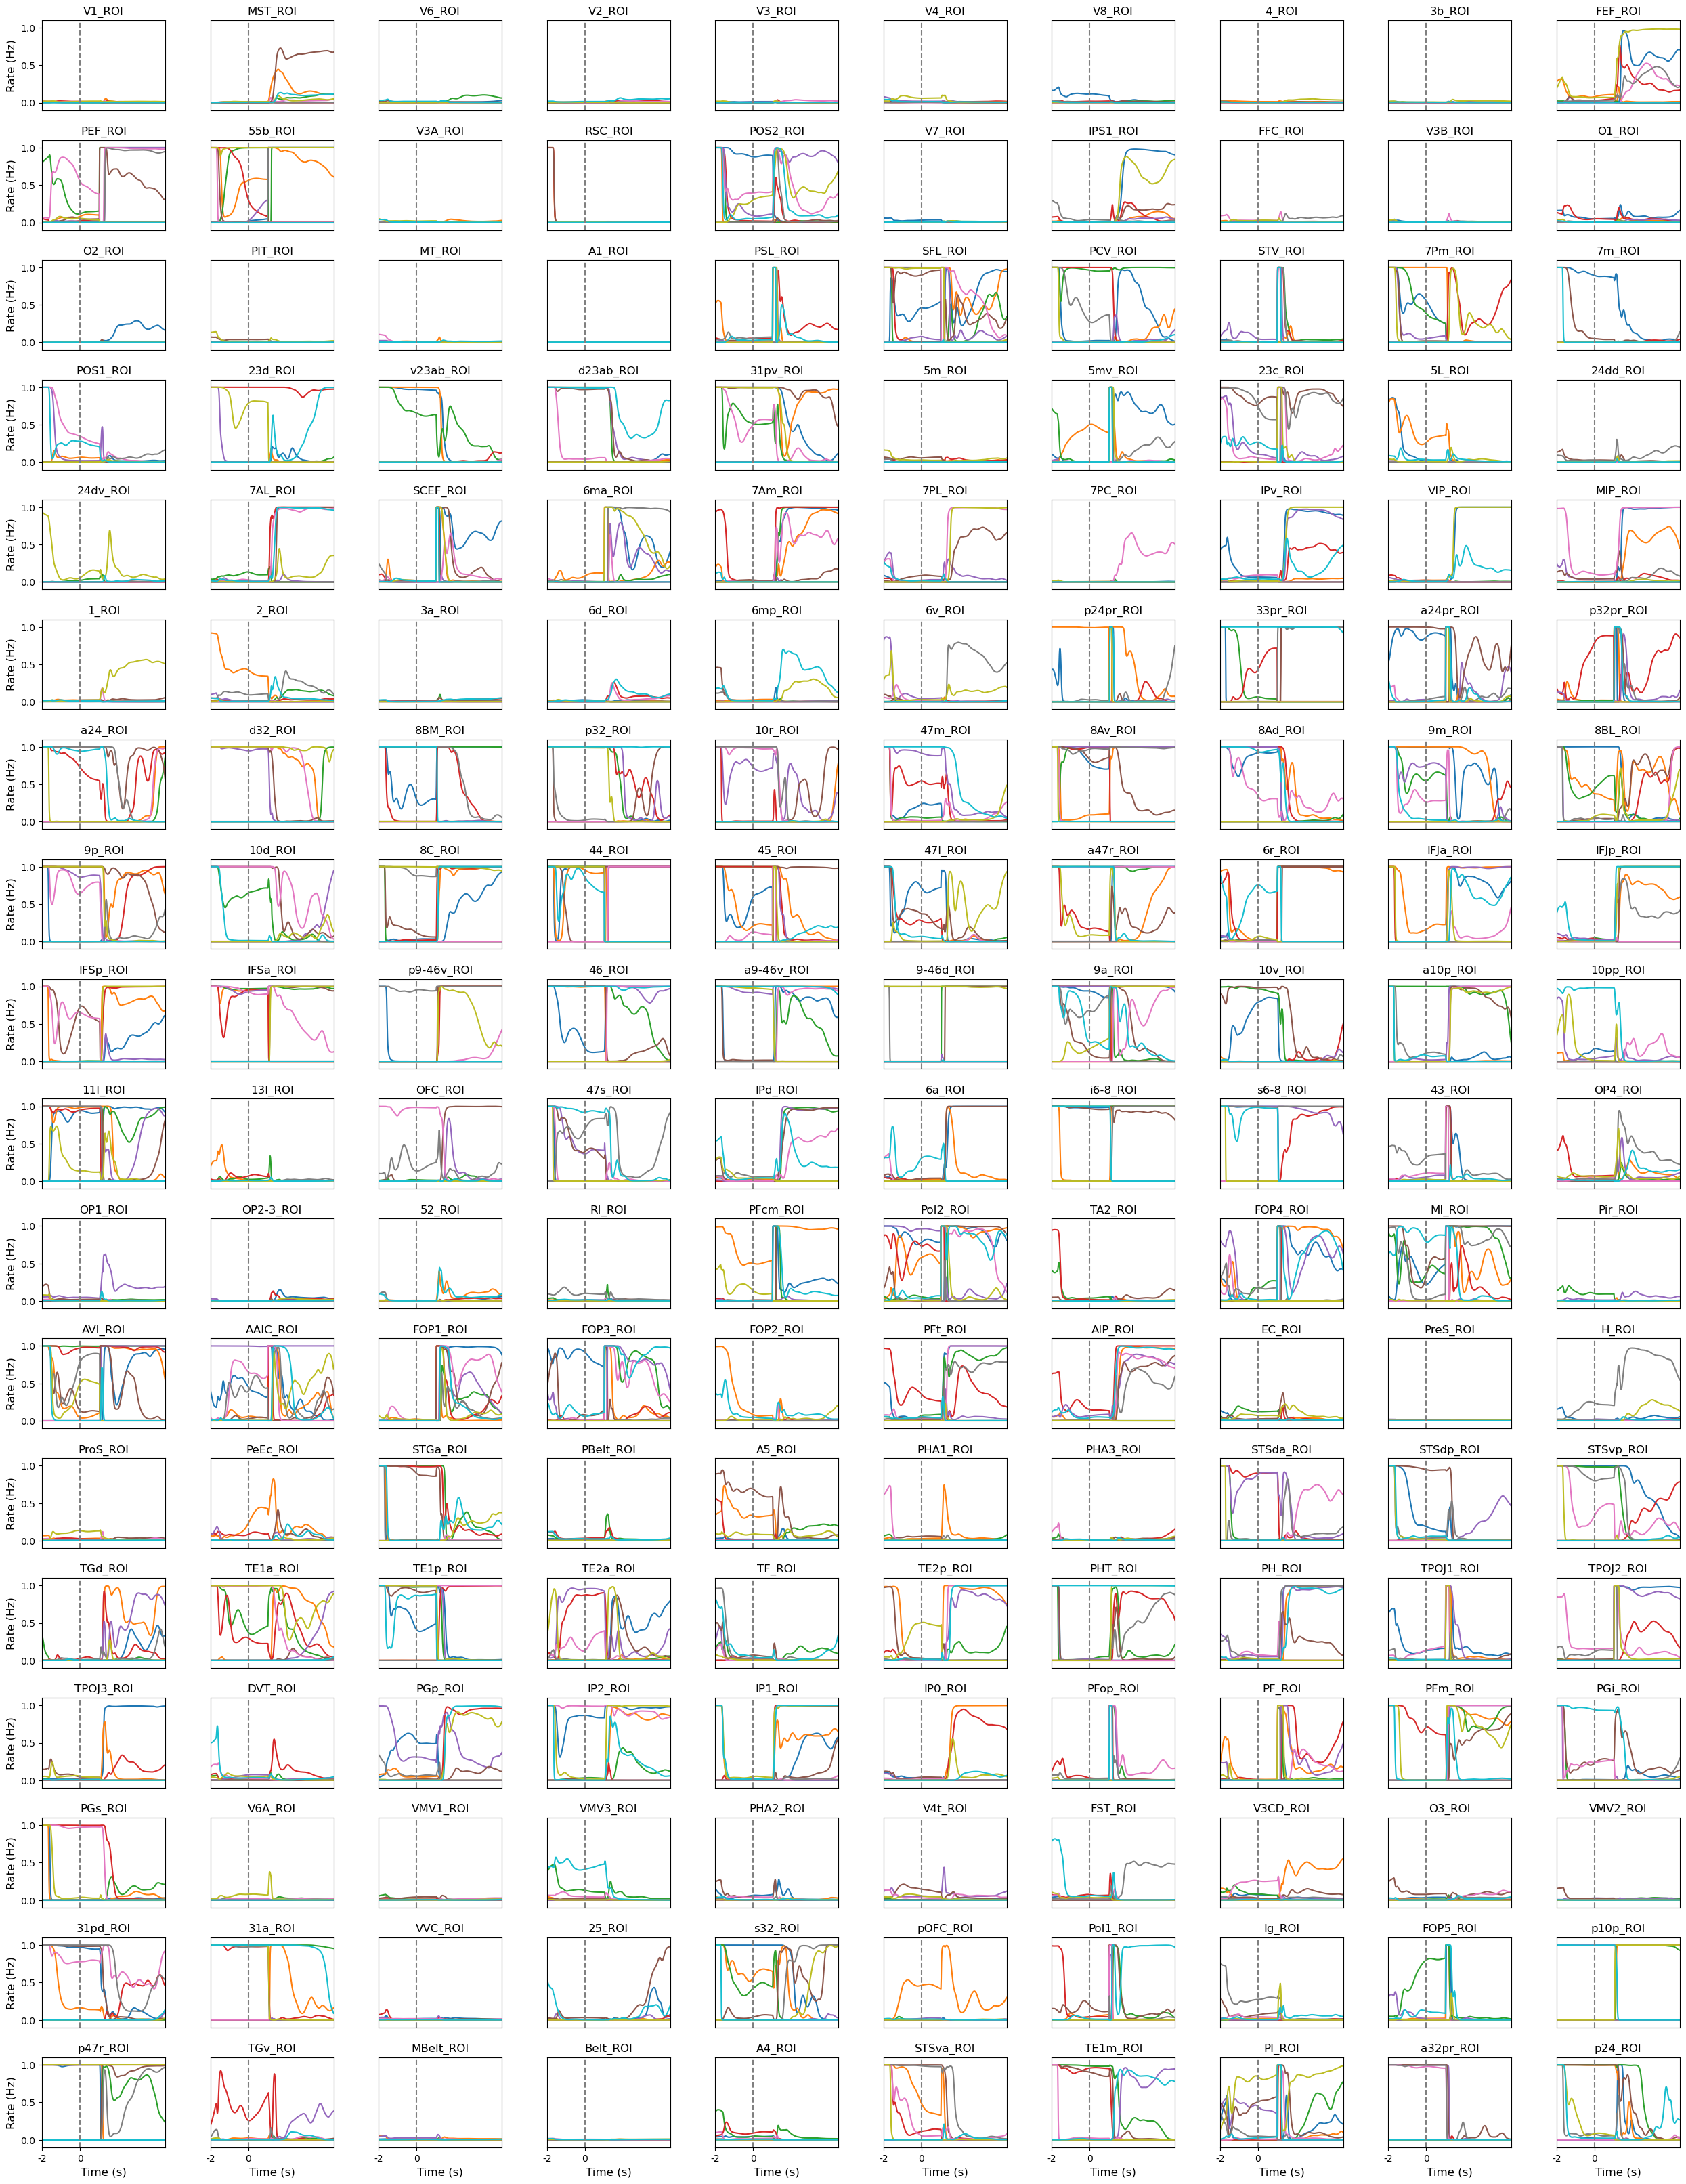

In [17]:
from cycler import cycler

modelparams = model_parameters()

#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results['time']
r_ctx = results['rates_ctx']

#name_grad = 'gradient_low_rank.pdf'


fs=12
N_block = modelparams['N_block'] # resolution saved nurons 
N_recorded = modelparams['N_recorded'] # resolution saved nurons 
N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
colors = plt.cm.hsv(np.linspace(0,1, N_neu))
#names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = modelparams['t_start'] 
t_stop = modelparams['period']
t_end = r_ctx.shape[0] * dt
    
# plotting altoghether 
fig, ax = plt.subplots(figsize=(25, 32),nrows=18, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        time = np.linspace(0, t_end , r_ctx.shape[0])
        if l<=179:
            ind_1 = l * N_neu
            ind_2 = (l+1) * N_neu
            #col.set_prop_cycle(cycler('color', colors))
            col.plot(time, r_ctx[:, ind_1: ind_2:20])
            col.set_title(areas['Row'][l].strip("L_"),fontsize = fs)
        col.set_ylim([-.1,1.1])
        #col.set_xlim([t_start - 2, t_start + 8])
        col.set_xlim([t_start - 2, t_end])
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
        if n_row!=17:
            col.set_xticks([])
        if n_col==0:
            col.set_ylabel('Rate (Hz)', fontsize =fs)
        if n_row==17:
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([x for x in np.arange(t_start-2, t_start+2,2)])
            col.set_xticklabels([x for x in np.arange(-2,2,2)])

        l+=1
        n_col+=1
    n_row+=1
    #plt.savefig(name, bbox_inches='tight')
#plt.savefig(name_grad, bbox_inches='tight')

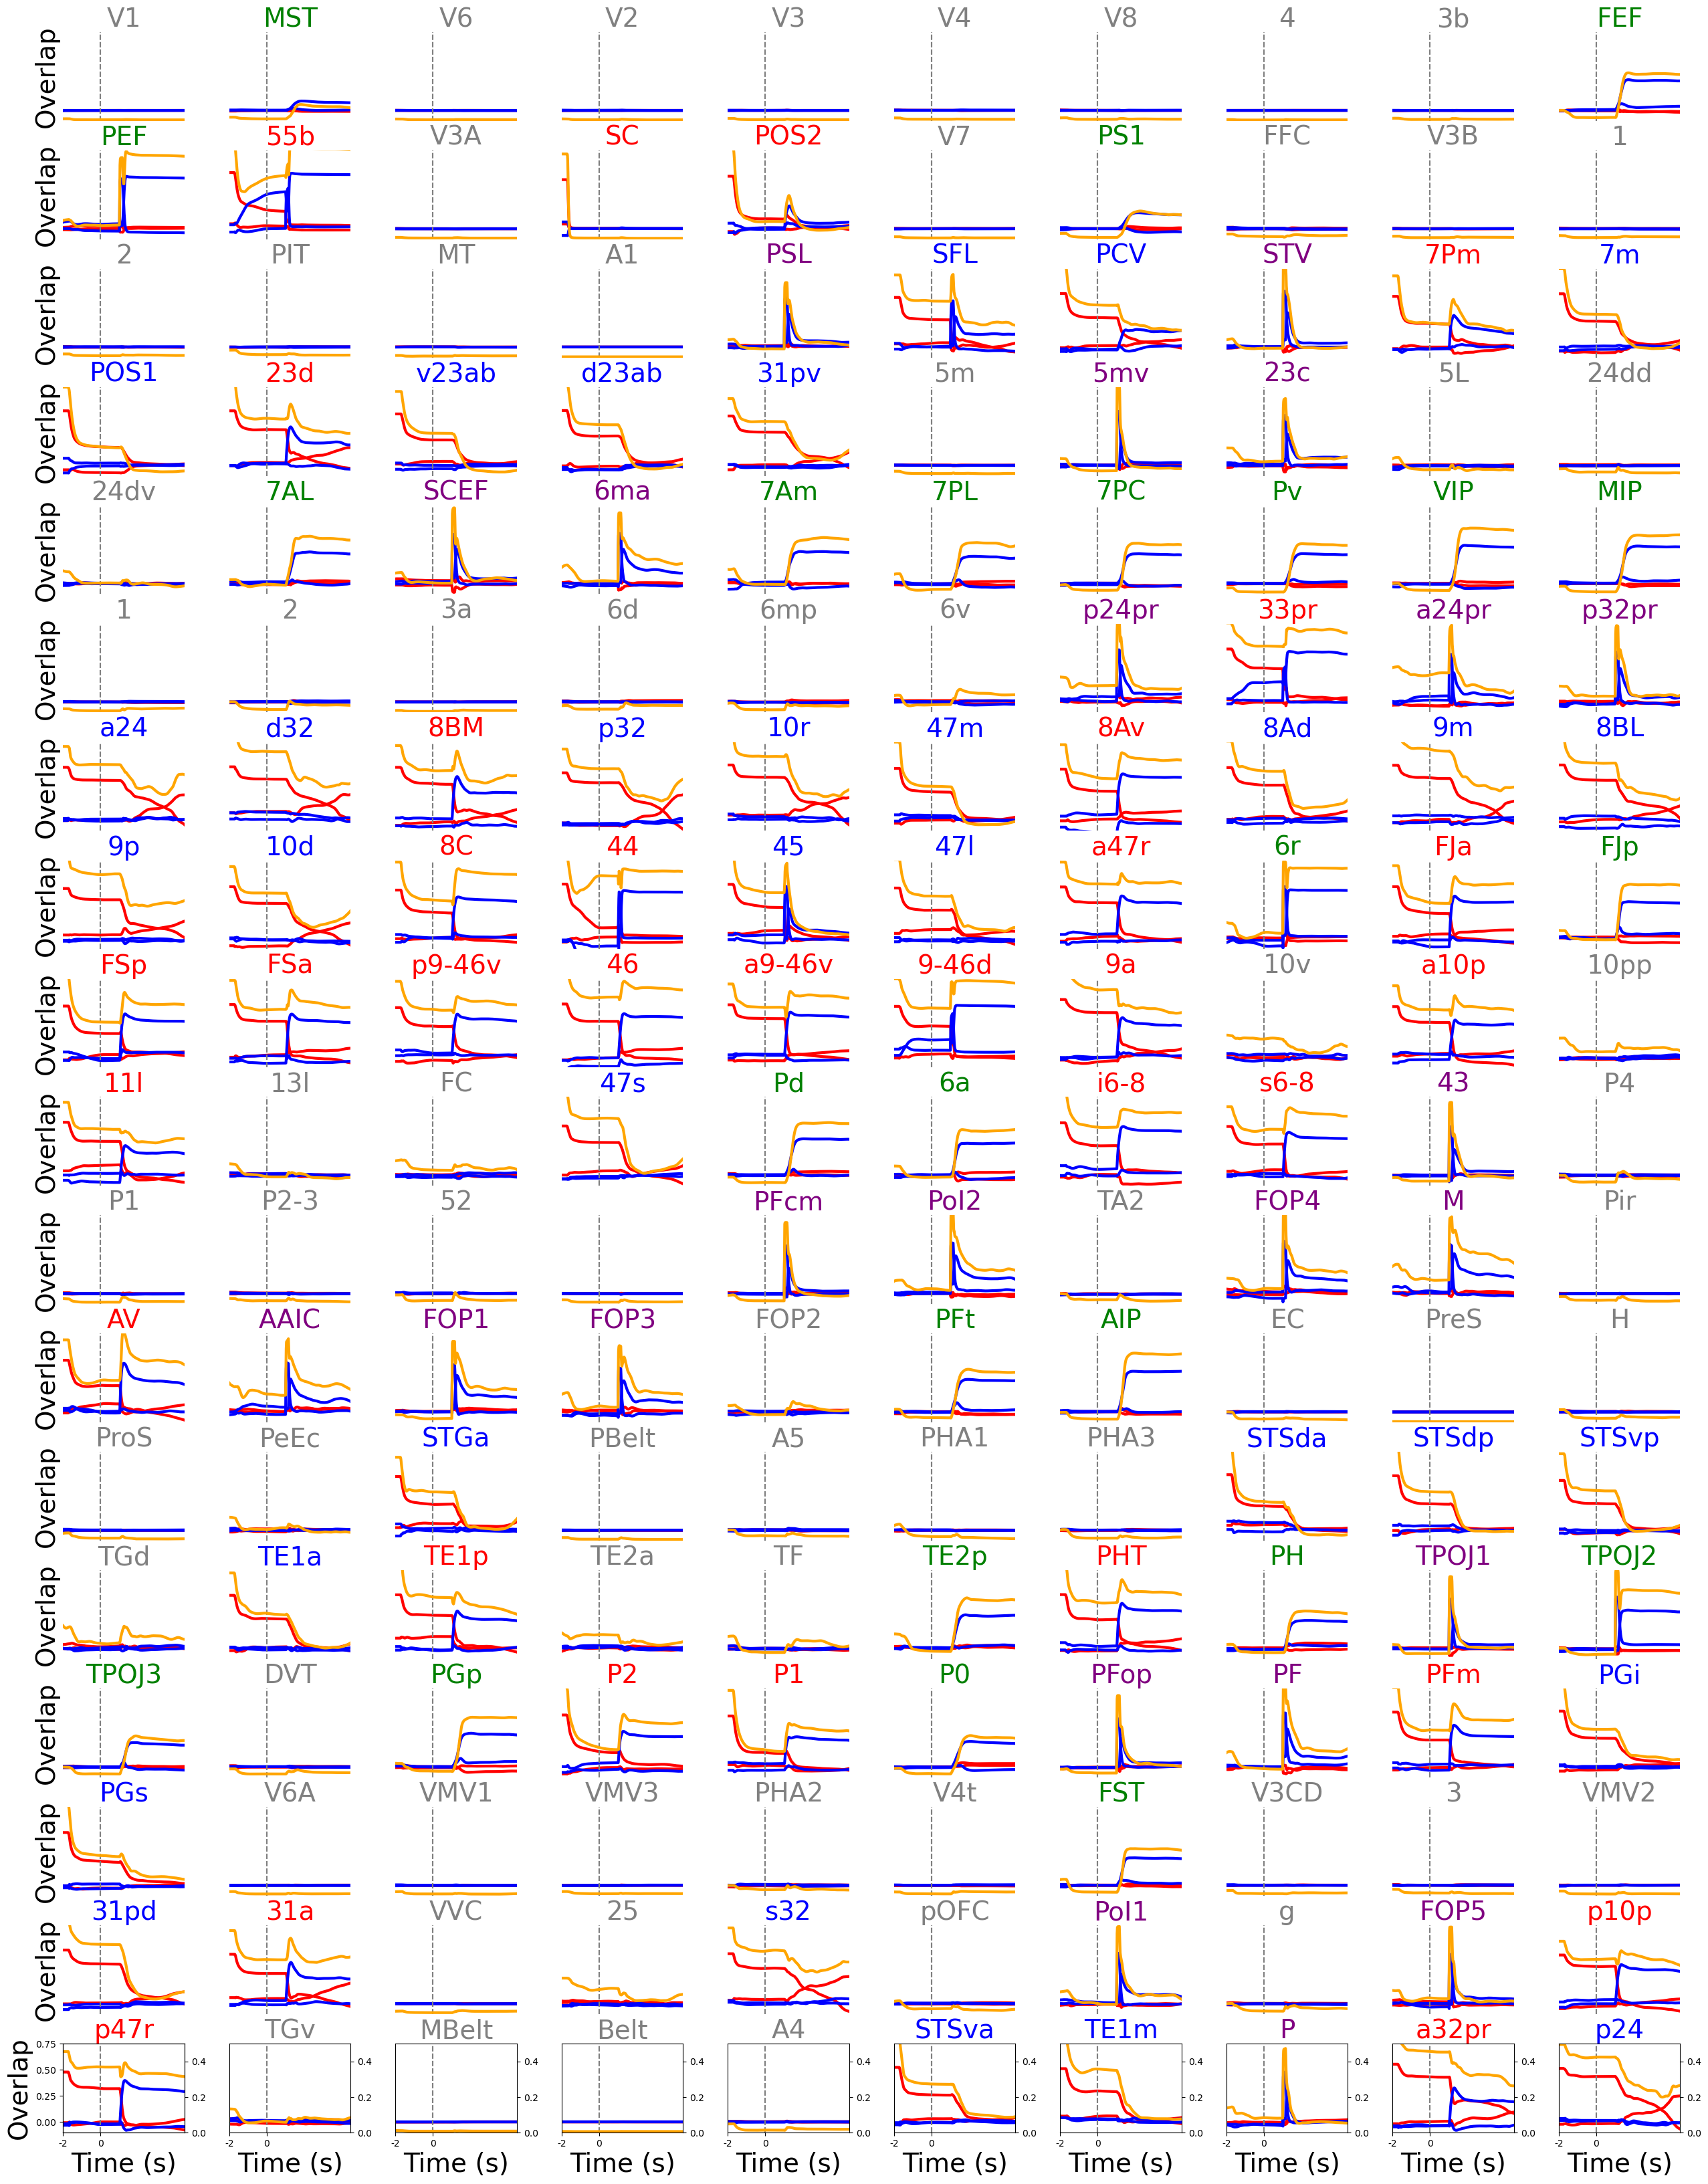

In [16]:

lw_ov = 3
lw_fr = 3
ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 20
fs=28

modelparams = model_parameters()

#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results['time']
r_ctx = results['rates_ctx']
overlaps = results['overlaps_sym']
#overlaps_choice = results['overlaps_choice']
overlaps_rand = results['overlaps_random']

name_grad = 'overlaps_low_rank.pdf'






N_block = modelparams['N_block']
p = overlaps.shape[2]
colors = plt.cm.hsv(np.linspace(0,1,N_block))
#names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = modelparams['t_start'] 
t_end = overlaps.shape[0] * dt
t_stop = modelparams['period']
time = np.linspace(0, t_end , overlaps.shape[0])
colors = ['b', 'r']
fig, ax = plt.subplots(figsize=(25, 32),nrows=18, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if l<=179:
                 #for s in range(p):
            if l in FPN:
                color = 'red'
            elif l in DMN:
                color = 'blue'
            elif l in DAN:
                color = 'green'
            elif l in salience:
                color = 'purple'
            else:
                color = 'grey'
            col.plot(time, overlaps[:, l, 0, :], lw =lw_ov, color = 'r')
            col.plot(time, overlaps[:, l, 1, :], lw =lw_ov, color = 'b')
            col.set_title((areas['Row'][l].strip("L_")).strip("_ROI"),fontsize = fs, color=color)
            axij = col.twinx()
            r_mean = np.mean(r_ctx[:, l * N_neu: (l + 1)* N_neu], axis = 1)
            axij.plot(time,  r_mean, color = m_fr_color, lw= lw_ov)
            axij.set_ylim([0,.5])
        col.set_xlim([t_start - 2, t_end])
        col.set_ylim([-.1, .75])
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
            col.set_xticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
        if n_row!=17:
            col.set_xticks([])
            col.set_yticks([])
            col.spines['right'].set_visible(False)
            col.spines['top'].set_visible(False)
            col.spines['left'].set_visible(False)
            col.spines['bottom'].set_visible(False)
            axij.set_xticks([])
            axij.set_yticks([])
            axij.spines['right'].set_visible(False)
            axij.spines['top'].set_visible(False)
            axij.spines['left'].set_visible(False)
            axij.spines['bottom'].set_visible(False)
        if n_col==0:
            col.set_ylabel('Overlap', fontsize =fs)
        if n_row==17:
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([x for x in np.arange(t_start-2, t_start+2,2)])
            col.set_xticklabels([x for x in np.arange(-2,2,2)])
        l+=1
        n_col+=1
    n_row+=1
#plt.savefig(str_ov, bbox_inches='tight')
#plt.close()
plt.savefig(name_grad, bbox_inches='tight')

In [ ]:
from scipy.io import savemat


In [ ]:
from cycler import cycler

modelparams = model_parameters()

#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results['time']
r_ctx = results['rates_ctx']


fs=12
N_block = modelparams['N_block'] # resolution saved nurons 
N_recorded = modelparams['N_recorded'] # resolution saved nurons 
N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
colors = plt.cm.hsv(np.linspace(0,1, N_neu))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = modelparams['t_start'] + 4
t_stop = modelparams['period']
t_end = r_ctx.shape[0] * dt
    
# plotting altoghether 
fig, ax = plt.subplots(figsize=(4, 3))
fig.tight_layout()
l=0
m_fr = []
for l in range(89):
    ind_1 = l * N_neu
    ind_2 = (l+1) * N_neu
    m_fr.append(np.mean(r_ctx[350:-1, ind_1: ind_2:]))
    if l in inds[s]:
        ax.plot(time, np.mean(r_ctx[:, ind_1: ind_2:], axis=1), color = 'r')
    else:
        ax.plot(time, np.mean(r_ctx[:, ind_1: ind_2:], axis=1), color = 'gray', alpha =1)
ax.set_xlim([t_start-2, t_end])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([5, 7, 9, 11])
ax.set_xticklabels([0, 2, 4, 6], fontsize = s_ticks)
ax.set_yticks([0, 0.2, 0.4])
ax.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)

#plt.savefig('figures/panels/firing_rates_all_symmetric.pdf', bbox_inches='tight')




In [ ]:
pickle.dump(m_fr, open('simulation_data/mean_fr.p', 'wb'))
pickle.dump(overlaps, open('simulation_data/overlaps.p', 'wb'))
pickle.dump([names_ctx[i] for i in inds[0]], open('simulation_data/areas_prefrontal.p', 'wb'))
pickle.dump([names_ctx[i] for i in connectivity_params['clustered_areas']['areas2']], open('simulation_data/areas_cingulate.p', 'wb'))

In [ ]:
# importing monkey connectivity
connectivity_params = loading_matrices(.3)

#model parameters
modelparams = model_parameters()
modelparams['amp_loc_noise'] = .4
modelparams['amp_lr_noise'] = 2.5#2.1
modelparams['amp_loc'] = 2.5
modelparams['amp_lr'] = 1.5

#names
inds_early_visual = connectivity_params['inds_early_visual']
names = connectivity_params['names_ctx']
names_ctx = []
for l in range(89):
    names_ctx.append(names[l])

#creating connectivity
connectivity = CorticalConnectivity(modelparams, connectivity_params)
connectivity.hebbian_symmetric.p_asym = 15
connectivity.hebbian_symmetric.p_sym = 1

inds = []
#inds.append(connectivity_params['cognitive_subnetworks']['DorsAtt'])
#inds.append(connectivity_params['cognitive_subnetworks']['Default'])
#inds.append(connectivity_params['cognitive_subnetworks']['Salience'])
#inds.append(connectivity_params['cognitive_subnetworks']['Limbic'])
#len_dorsatt = float(len(connectivity_params['cognitive_subnetworks']['DorsAtt']))
#len_default = float(len(connectivity_params['cognitive_subnetworks']['Default']))
amp_inds = [(0,2)] 
#inds.append(connectivity_params['clustered_areas']['areas5'])
inds.append(connectivity_params['clustered_areas']['areas2'])
#inds.append([64])
connectivity.hebbian_symmetric.update_indexes(inds, amp_inds)


In [ ]:
connectivity_params['clustered_areas']['areas2']

In [ ]:
#creating network
modelparams['period'] = 5.

modelparams['beta'] = 1.5
modelparams['h0'] = 1.05#1.1
modelparams['g_p'] = 0

task = working_memory_task(modelparams, connectivity)
task.i_pat = 0 * task.i_pat
task.ind_stim=51
task.pat_input()
network = NetworkDynamics(modelparams, connectivity)
network.overlaps.is_sym = False
network.input_ctx = task.input_current
#network.which_tf = 'sig'

#running dynamics
s0_ctx =  0 * np.random.uniform(0,.1, network.mat.shape[0])
s = 0
amp_in = 10#100000
for l in inds[s]:
    Nl = l * connectivity.N
    Nlp1 = (l + 1) * connectivity.N
    s0_ctx[Nl : Nlp1] = amp_in * connectivity.hebbian_symmetric.patterns_current_asym[l, :, s, 0]
results = network.dynamics(s0_ctx)

In [ ]:
from cycler import cycler

modelparams = model_parameters()

#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results['time']
r_ctx = results['rates_ctx']

#name_grad = 'gradient_low_rank.pdf'


fs=12
N_block = modelparams['N_block'] # resolution saved nurons 
N_recorded = modelparams['N_recorded'] # resolution saved nurons 
N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
colors = plt.cm.hsv(np.linspace(0,1, N_neu))
names_ctx, inds_full = names_inds_ctx()
dt = modelparams['dt']
t_start = 0#modelparams['t_start'] 
t_stop = modelparams['period']
t_end = r_ctx.shape[0] * dt
    
# plotting altoghether 
fig, ax = plt.subplots(figsize=(20, 16),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        time = np.linspace(0, t_stop , r_ctx.shape[0])
        if l<=88:
            ind_1 = l * N_neu
            ind_2 = (l+1) * N_neu
            #col.set_prop_cycle(cycler('color', colors))
            col.plot(time, r_ctx[:, ind_1: ind_2:20])
            col.set_title(names_ctx[l],fontsize = fs)
        col.set_ylim([-.1,1.1])
        #col.set_xlim([t_start - 2, t_start + 8])
        col.set_xlim([t_start, t_end])
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if n_col!=0:
            col.set_yticks([])
        if n_row!=9:
            col.set_xticks([])
        if n_col==0:
            col.set_ylabel('Rate (Hz)', fontsize =fs)
        if n_row==9:
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([x for x in np.arange(t_start-2, t_start+2,2)])
            col.set_xticklabels([x for x in np.arange(-2,2,2)])

        l+=1
        n_col+=1
    n_row+=1
    #plt.savefig(name, bbox_inches='tight')


In [ ]:
from cycler import cycler

modelparams = model_parameters()

#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results['time']
r_ctx = results['rates_ctx']
overlaps = results['overlaps_sym']



fs=12
N_block = modelparams['N_block']
p = overlaps.shape[2]
colors = plt.cm.hsv(np.linspace(0,1,N_block))
names_ctx, inds_full = names_inds_ctx()



dt = modelparams['dt']
t_start = 0 #modelparams['t_start'] + 4
#ind_start = int(t_start/dt)
t_stop = modelparams['period']
#ind_end = int(t_stop/dt)

t_end =8 #overlaps[ind_start:ind_end].shape[0] * dt

time = np.linspace(0, t_stop , overlaps.shape[0])
colors = ['b', 'r']
fig, ax = plt.subplots(figsize=(20, 18),nrows=9, ncols=10)
fig.tight_layout()
l=0
n_row= 0
for row in ax:
    n_col=0
    for col in row:
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if l<89:
            for s in range(p):
                col.plot(time, overlaps[:, l, s])
            col.set_title(names_ctx[l],fontsize = fs)
        col.set_xlim([t_start, t_end])
        col.set_ylim([-.05, .65])
        col.axvline(x=t_start, ymin=0, ymax=200, ls = '--',color='gray')
        if n_row!=9:
            col.set_xticks([])
        if n_col==0:
            col.set_ylabel('Overlap', fontsize =fs)
        if n_row==9:
            col.set_xlabel('Time (s)', fontsize = fs)
            col.set_xticks([x for x in np.arange(t_start-2, t_start+2, 2)])
            col.set_xticklabels([x for x in np.arange(-2,2,2)])
        l+=1
        n_col+=1
    n_row+=1
#plt.savefig(str_ov, bbox_inches='tight')
#plt.close()
#plt.savefig(name_grad, bbox_inches='tight')

In [ ]:
overlaps = results['overlaps_sym']
fig, ax = plt.subplots(figsize=(4, 3))
fig.tight_layout()
for s in [0]:
        for l in range(89):
          if l in inds[s]:
               ax.plot(time, overlaps[:, l, s], color = 'r')
          elif l==names_ctx.index('V1'):
               ax.plot(time, overlaps[:, l, s], color = 'r')
          elif l==names_ctx.index('24d'):
               ax.plot(time, overlaps[:, l, s], color = 'r')
          else:
                ax.plot(time, overlaps[:, l, s], color = 'gray', alpha =1 )
ax.set_xlim([t_start, t_end])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 2, 4])
ax.set_xticklabels([0, 1, 2], fontsize = s_ticks)
ax.set_yticks([0, 0.2, 0.4])
ax.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)

plt.savefig('figures/panels/overlaps_all_asymmetric.pdf', bbox_inches='tight')


In [ ]:
from cycler import cycler

modelparams = model_parameters()

#results = pickle.load(open('data/gradient_chaos/sim_0.011.p', 'rb'))
time = results['time']
r_ctx = results['rates_ctx']


fs=12
N_block = modelparams['N_block'] # resolution saved nurons 
N_recorded = modelparams['N_recorded'] # resolution saved nurons 
N_neu =int( N_block/int(N_block/N_recorded)) #number recorded neurons
colors = plt.cm.hsv(np.linspace(0,1, N_neu))
names_ctx, inds_full = names_inds_ctx()
# plotting altoghether 
fig, ax = plt.subplots(figsize=(4, 3))
fig.tight_layout()
l=0
m_fr = []
for l in range(89):
    ind_1 = l * N_neu
    ind_2 = (l+1) * N_neu
    m_fr.append(np.mean(r_ctx[350:-1, ind_1: ind_2:]))
    if l in inds[s]:
        ax.plot(time, np.mean(r_ctx[:, ind_1: ind_2:], axis=1), color = 'r')
    else:
        ax.plot(time, np.mean(r_ctx[:, ind_1: ind_2:], axis=1), color = 'gray', alpha =1)
ax.set_xlim([t_start, t_end])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([0, 1, 2], fontsize = s_ticks)
ax.set_yticks([0, 0.2, 0.4])
ax.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)

plt.savefig('figures/panels/firing_rates_all_asymmetric.pdf', bbox_inches='tight')

In [ ]:

time = results['time']
r_ctx = results['rates_ctx']
overlaps = results['overlaps_sym']


ov_color = 'blue'
m_fr_color = 'orange'
s_ticks = 18

dt = modelparams['dt']
t_start = 0 #modelparams['t_start'] + 4
#ind_start = int(t_start/dt)
t_stop = modelparams['period']
#ind_end = int(t_stop/dt)

t_end = 2 #overlaps[ind_start:ind_end].shape[0] * dt

#time = np.linspace(0, t_stop , overlaps.shape[0])

colors1 = plt.cm.Blues(np.linspace(0,1, N_neu))
colors2 = plt.cm.Reds(np.linspace(0, 1 , N_neu))
colors_greens = plt.cm.Purples(np.linspace(0, 1 , N_neu))

fig, ax = plt.subplots(figsize=(14, 4),nrows=2, ncols=3)


#frist column
ind1 = names_ctx.index('25')
for l in range(ind1* N_neu, (ind1+1)* N_neu, 18):
    ax[0,0].plot(time, r_ctx[:, l], color = colors_greens[l-ind1* N_neu])
ax[0,0].set_ylim([0,1.1])
ax[0,0].set_xticks([])
ax[0, 0].spines['right'].set_visible(False)
ax[0, 0].spines['top'].set_visible(False)
ax[0,0].spines['bottom'].set_visible(False)
ax[0, 0].set_xlim([t_start, t_end])
ax[0, 0].set_yticks([0, 0.5, 1])
ax[0, 0].set_yticklabels([0, 0.5, 1], fontsize = s_ticks)

ax[1,0].plot(time, overlaps[:, ind1, 0], color = ov_color)
ax[1,0].set_ylim([-.1,0.5])
ax[1, 0].set_xlim([t_start, t_end])
ax[1, 0].spines['right'].set_visible(False)
ax[1, 0].spines['top'].set_visible(False)
ax[1, 0].set_xticks([0, 1, 2])
ax[1, 0].set_xticklabels([0, 1, 2], fontsize = s_ticks)
ax[1, 0].set_yticks([0, 0.2, 0.4])
ax[1, 0].set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)

ax10 = ax[1,0].twinx()
r_mean1 = np.mean(r_ctx[:, ind1* N_neu: (ind1+1)* N_neu], axis = 1)
ax10.plot(time,  r_mean1, color = m_fr_color)
ax10.set_ylim([0,0.41])
ax10.set_xlim([t_start, t_end])
ax10.spines['right'].set_visible(False)
ax10.spines['top'].set_visible(False)
ax10.set_yticks([])


#second column

ind2 = names_ctx.index('24d')
for l in range(ind2* N_neu, (ind2+1)* N_neu, 18):
    ax[0,1].plot(time, r_ctx[:, l],  color = colors2[l - ind2* N_neu])
ax[0,1].set_ylim([0,1.1])
ax[0,1].set_xticks([])
ax[0, 1].spines['right'].set_visible(False)
ax[0, 1].spines['top'].set_visible(False)
ax[0, 1].spines['left'].set_visible(False)
ax[0, 1].spines['bottom'].set_visible(False)
ax[0, 1].set_xlim([t_start, t_end])
ax[0, 1].set_yticks([])

ax[1,1].plot(time, overlaps[:, ind2, 0], color = ov_color)
ax[1,1].set_ylim([-.1,0.5])
ax[1, 1].set_xlim([t_start, t_end])
ax[1, 1].spines['right'].set_visible(False)
ax[1, 1].spines['top'].set_visible(False)
ax[1, 1].spines['left'].set_visible(False)
ax[1, 1].set_yticks([])
ax[1, 1].set_xticks([0, 1, 2])
ax[1, 1].set_xticklabels([0, 1, 2], fontsize = s_ticks)

ax11 = ax[1,1].twinx()
r_mean2 = np.mean(r_ctx[:, ind2 * N_neu: (ind2+1) * N_neu], axis = 1)
ax11.plot(time,  r_mean2, color = m_fr_color)
ax11.set_ylim([0,0.41])
ax11.set_xlim([t_start, t_end])
ax11.spines['right'].set_visible(False)
ax11.spines['top'].set_visible(False)
ax11.spines['left'].set_visible(False)
ax11.set_yticks([])

#third column

ind3 = names_ctx.index('24c')
for l in range(ind3* N_neu, (ind3+1)* N_neu, 18):
    ax[0,2].plot(time, r_ctx[:, l], color = colors1[l-ind3* N_neu])
ax[0,2].set_ylim([0,1.1])
ax[0,2].set_xticks([])
ax[0, 2].spines['right'].set_visible(False)
ax[0, 2].spines['top'].set_visible(False)
ax[0,2].spines['left'].set_visible(False)
ax[0,2].spines['bottom'].set_visible(False)
ax[0, 2].set_xlim([t_start, t_end])
ax[0, 2].set_yticks([])

ax[1,2].plot(time, overlaps[:, ind3, 0], color = ov_color)
ax[1,2].set_ylim([-.1,0.5])
ax[1, 2].set_xlim([t_start, t_end])
ax[1, 2].spines['right'].set_visible(False)
ax[1, 2].spines['top'].set_visible(False)
ax[1, 2].spines['left'].set_visible(False)
ax[1, 2].set_yticks([])
ax[1, 2].set_xticks([0, 1, 2])
ax[1, 2].set_xticklabels([0, 1, 2], fontsize = s_ticks)

ax12 = ax[1,2].twinx()
r_mean3 = np.mean(r_ctx[:, ind3* N_neu: (ind3+1)* N_neu], axis = 1)
ax12.plot(time,  r_mean3, color = m_fr_color)
ax12.set_ylim([0,.41])
ax12.set_xlim([t_start, t_end])
#ax12.spines['right'].set_visible(False)
ax12.spines['top'].set_visible(False)
ax12.spines['left'].set_visible(False)
ax12.set_yticks([0, 0.2, 0.4])
ax12.set_yticklabels([0, 0.2, 0.4], fontsize = s_ticks)

plt.savefig('figures/panels/25_24d_24c_sequences.pdf', bbox_inches='tight')

In [ ]:
if False: # saving cognitive subnetworks
    df = pandas.read_csv('connectivity_data/lyon_regions_cog_networks_overlap.csv')

    subnet_Visual = []
    subnet_SomMot = []
    subnet_DorsAtt = []
    subnet_Salience = []
    subnet_Limbic = []
    subnet_FPN = []
    subnet_Default = []


    def add_area_subnet(new_name, i, thres = 0.1):
        if df['Visual'][i]>thres:
            subnet_Visual.append(names_ctx.index(new_name))
        if df['SomMot'][i]>thres:
            subnet_SomMot.append(names_ctx.index(new_name))
        if df['DorsAtt'][i]>thres:
            subnet_DorsAtt.append(names_ctx.index(new_name))
        if df['Salience'][i]>thres:
            subnet_Salience.append(names_ctx.index(new_name))
        if df['Limbic'][i]>thres:
            subnet_Limbic.append(names_ctx.index(new_name)) 
        if df['FPN'][i]>thres:
            subnet_FPN.append(names_ctx.index(new_name)) 
        if df['Default'][i]>thres:
            subnet_Default.append(names_ctx.index(new_name))
    

    i=0
    for r in list(df['Row']):
        if r in list(names_ctx):
            new_name = r
            add_area_subnet(new_name, i)
        elif r == '7A':
            new_name = '7a'
            add_area_subnet(new_name, i)
        elif r=='7B':
            new_name = '7b'
            add_area_subnet(new_name, i)
        elif r=='ENTORHINAL':
            new_name = 'ENTO'
            add_area_subnet(new_name, i)
        elif r=='INSULA':
            new_name = 'INS'
            add_area_subnet(new_name, i)
        elif r=='Parainsula':
            new_name = 'Pi'
            add_area_subnet(new_name, i)
        elif r=='PERIRHINAL':
            new_name = 'PERI'
            add_area_subnet(new_name, i)
        elif r=='Pro.St':
            new_name = 'Pro.St.'
            add_area_subnet(new_name, i)
        elif r=='TEMPORAL_POLE':
            new_name = 'POLE'
            add_area_subnet(new_name, i)
        elif r=='SUBICULUM':
            print('No SUBICULUM in the 89 areas network')
        elif r=='PIRIFORM':
            print('No PIRIFORM in the 89 areas network')
        i+=1


    subnetworks = dict(Visual = subnet_Visual, 
                    SomMot = subnet_SomMot,
                    DorsAtt =  subnet_DorsAtt, 
                    Salience = subnet_Salience,
                    Limbic = subnet_Limbic,
                    FPN = subnet_FPN,
                    Default = subnet_Default
                    )
    pickle.dump(subnetworks, open('connectivity_data/cognitive_subnetworks.p', 'wb'))